In [3]:
from datasets import load_dataset
import json
import requests
from bs4 import BeautifulSoup, Comment
from bs4 import Tag

d:\Miniconda3\envs\rag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from collections import deque

In [5]:
ds = load_dataset("google-research-datasets/natural_questions", "dev", split='validation')

In [225]:
i = 4

In [226]:
sample1 = ds[i]['document']['html']

'<!DOCTYPE html>\n<HTML class="client-js ve-not-available" lang="en" dir="ltr"><HEAD>\n\n<TITLE>NBA All-Star Game Most Valuable Player Award - Wikipedia</TITLE>\n\n\n<LINK rel="stylesheet" href="/w/load.php?debug=false&amp;lang=en&amp;modules=ext.cite.styles%7Cext.uls.interlanguage%7Cext.visualEditor.desktopArticleTarget.noscript%7Cext.wikimediaBadges%7Cmediawiki.legacy.commonPrint%2Cshared%7Cmediawiki.sectionAnchor%7Cmediawiki.skinning.interface%7Cskins.vector.styles%7Cwikibase.client.init&amp;only=styles&amp;skin=vector" />\n\n<STYLE>\n.referencetooltip{position:absolute;list-style:none;list-style-image:none;opacity:0;font-size:12px;margin:0;z-index:5;padding:0}.referencetooltip > li{background:#fff;border:1px solid #bbb;-webkit-box-shadow:0 0 10px rgba(0,0,0,0.2);-moz-box-shadow:0 0 10px rgba(0,0,0,0.2);box-shadow:0 0 10px rgba(0,0,0,0.2);margin:0;padding:8px 10px;line-height:18px;max-width:300px}.referencetooltip > li + li{box-sizing:border-box;margin-left:7px;margin-top:-1px;borde
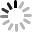

In [227]:
sample1

In [228]:
ques1 = ds[i]['question']['text']
token_list1 = ds[i]['document']['tokens']
short_answer = ds[i]['annotations']
long_answer = ds[i]['long_answer_candidates']


In [123]:
long_answer.keys()

dict_keys(['start_token', 'end_token', 'start_byte', 'end_byte', 'top_level'])

In [ ]:

for candidate in zip(long_answer['start_token'], long_answer['end_token'], long_answer['start_byte'], long_answer['end_byte'], long_answer['top_level']):
        start_byte, end_byte = candidate[2], candidate[3]
        start_token, end_token = candidate[0], candidate[1]
        if candidate[4] is True:
            print(start_byte, end_byte, start_token, end_token)

            print(sample1[start_byte:end_byte])
            print(token_list1['token'][start_token], token_list1['token'][end_token])
    

In [48]:
sample2 = """<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>More Complex Example</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
            margin: 20px;
        }
        .container {
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            border: 1px solid #ccc;
        }
        h1, h2 {
            color: #333;
        }
        p {
            margin-bottom: 15px;
        }
        ul {
            list-style-type: disc;
            padding-left: 20px;
        }
        a {
            color: blue;
            text-decoration: none;
        }
        a:hover {
            text-decoration: underline;
        }
        #important {
            font-weight: bold;
            color: red;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Welcome to My Website</h1>
        <p>This is a more detailed example with additional content and styling. We're exploring various HTML elements and CSS properties.</p>

        <h2>Section 1: Introduction</h2>
        <p>This section provides an overview of the topic. We'll discuss key concepts and provide context.</p>
        <ul>
            <li>Point 1: A key feature.</li>
            <li>Point 2: Another important aspect.</li>
            <li>Point 3: A supporting detail.</li>
        </ul>

        <h2>Section 2: Further Details</h2>
        <p>Here, we delve deeper into the subject matter. You can find more information and examples below.</p>
        <p id="important">This is an important paragraph with special styling.</p>
        <a href="https://www.example.com">Visit Example Website</a>

        <div>
          <h3>A Sub Section</h3>
          <p>Some more text here</p>
          <img src="dummy_image.jpg" alt="Dummy Image" width="300">
        </div>
    </div>
</body>
</html>"""

In [109]:
class BlockNode:
    def __init__(self, tag, attributes = None, content = None):
        self.tag = tag
        self.attributes = attributes or {}
        self.content = content.strip() if content else ""
        self.children = []
        self.block = ""
        self.is_leaf = False
        self.embedding = None

    def add_child(self, child):
        self.children.append(child)

    def to_dict(self):
        return {
            "tag": self.tag,
            "attributes": self.attributes,
            "content": self.content,
            "children": [child.to_dict() for child in self.children],
        }

In [194]:
def clean_html(html_content):
    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Step 1: HTML Content Cleaning
    # Remove <script>, <style>, and comments
    for tag in soup(["script", "style"]):
        tag.decompose()
    for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
        comment.extract()
    
    # Remove lengthy attributes (e.g., inline styles, large data attributes)
    def clean_attributes(tag):
        for attr in list(tag.attrs.keys()):
            if len(str(tag[attr])) > 50:  # Arbitrary threshold for "lengthy"
                del tag[attr]
    
    for tag in soup.find_all(True):  # All tags
        clean_attributes(tag)
    
    # Step 2: Lossless Structural Compression
    # Merge single-nested tags
    def merge_single_nested_tags(tag):
        while len(tag.contents) == 1 and isinstance(tag.contents[0], Tag) and tag.contents[0].name == tag.name:
            child = tag.contents[0]
            tag.attrs.update(child.attrs)  # Merge attributes
            tag.contents = child.contents  # Replace contents
        for child in tag.find_all(recursive=False):
            merge_single_nested_tags(child)
    # Remove all \t and \n in the data
    for text in soup.find_all(string=True):
        text.replace_with(text.replace('\n', '').replace('\t', ''))
    for tag in soup.find_all(True):  # All tags
        merge_single_nested_tags(tag)
    
    # Remove empty tags
    for tag in soup.find_all():
        if not tag.contents or all(str(content).strip() == "" for content in tag.contents):
            tag.decompose()

    return soup

In [15]:
def build_dom_tree(html_content):
    def build_tree(element):
        if not element.name:
            return None

        # Create a BlockNode for the current element
        node = BlockNode(
            tag=element.name,
            attributes=element.attrs,
            content=element.get_text(strip=True) if element.string else "",
        )
        # print(node.attributes, node.content)
        # Recursively process children
        for child in element.children:
            child_node = build_tree(child)
            if child_node:
                node.add_child(child_node)
        
        return node
    root = build_tree(html_content)
    return root

In [137]:
def build_block_tree(dom_tree: BlockNode, max_window: int):
    """
    Construct a Block Tree from a DOM Tree.

    Args:
        dom_tree (BlockNode): The root of the DOM tree.
        max_window (int): The maximum token limit for a block.

    Returns:
        BlockNode: The root of the constructed Block Tree.
    """

    def merge_children_content(node: BlockNode, max_window):
        """Merge content of children nodes."""
        grand_children = []
        child_block = []
        for child in node.children:
            print(child.tag, child.content)
            grand_children.extend(child.children)
            child_block.append(child.content)
        # If the total content of children is less than the max window, add it to the block
        # print(" ".join(child_block), max_window)
        if len(" ".join(child_block).split()) < max_window:
            node.block += " ".join(child_block)
            node.children = grand_children
            return merge_children_content(node, max_window - len(node.block.split()) - 1)
        return node.children

    def split_content(content, max_window):
        """Split content into chunks within the token limit."""
        tokens = content.split()
        return [" ".join(tokens[i:i + max_window]) for i in range(0, len(tokens), max_window)]

    def build_block_tree_bfs(root: BlockNode, max_window):
        queue = deque([root])
        while queue:
            node = queue.popleft()
            if not node.children:
                node.block = node.content if node.content.strip() else ""
                node.is_leaf = True
                continue
            node.block = node.content if node.content.strip() else ""
            if len(node.block.split()) < max_window:
                merge_children_content(node, max_window - len(node.block.split()) - 1)
                if not node.children:
                    node.is_leaf = True
                else:
                    queue.extend(node.children)
                    node.is_leaf = False
            else:
                queue.extend(node.children)
                node.is_leaf = False

        return root

    new_tree = build_block_tree_bfs(dom_tree, max_window)
    return new_tree


In [35]:
a = True
a &= False
a

False

In [135]:
content

html<html class="client-js ve-not-available" dir="ltr" lang="en"><head><title>Wave–particle duality - Wikipedia</title></head><body> <div class="mw-body" id="content" role="main"><h1 class="firstHeading" id="firstHeading" lang="en">Wave–particle duality</h1> <div class="mw-body-content" id="bodyContent"><div class="noprint" id="siteSub">From Wikipedia, the free encyclopedia</div> <div class="mw-jump" id="jump-to-nav">Jump to:, </div><div class="mw-content-ltr" dir="ltr" id="mw-content-text" lang="en"><div class="mw-parser-output"><table role="presentation"><tbody><tr><td class="mbox-image"></td><td class="mbox-text"><div class="mbox-text-span">This article <b>needs additional citations for </b>. <span class="hide-when-compact">Please help  by . Unsourced material may be challenged and removed.</span> <small><i>(May 2014)</i></small> <small class="hide-when-compact"><i>()</i></small></div></td></tr></tbody></table><table><tbody><tr><td style="padding-top:0.4em;line-height:1.2em">Part of

In [ ]:
content = clean_html(sample1)
# content.find_all()
dom_tree = build_dom_tree(content)
tree = build_block_tree(dom_tree, 2000)

In [196]:
def print_tree_blocks(node: BlockNode, depth=0):
    """Print tree structure with tag and block contents."""
    if not node:
        return
    print("  " * depth + f"Tag: {node.tag}, Block: {node.block}, {node.is_leaf}")
    for child in node.children:
        # print(child.content)
        print_tree_blocks(child, depth + 1)

print_tree_blocks(tree)

Tag: [document], Block:  Current members of the United States Senate - Wikipedia     Current members of the United States Senate  Navigation menu      From Wikipedia, the free encyclopedia               This page was last edited on 25 January 2018, at 01:24.  Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previews   navigation search   https://en.wikipedia.org/w/index.php?title=Current_members_of_the_United_States_Senate&oldid=822209735   Personal tools       Navigation  Interaction  Tools  Print/export  In other projects  Languages  Creative Commons Attribution-ShareAlike License Terms of Use Privacy Policy Wikimedia Foundation, Inc. Privacy policy About Wikipedia Disclaimers Contact Wikipedia Developers Cookie statement Mobile view Enable previews                             Categories   Not logged in Talk Contributions Create account Log in Namespaces    Views  More          Edit links United States Senate states 115th Uni

In [197]:
EMB_MODEL_ID = "text-embedding-nomic-embed-text-v1.5"

def fetch_embedding(text):
    """Fetch embedding for a given text from LMStudio."""
    try:
        url = "http://localhost:9999/v1/embeddings"
        data = {
            "model": EMB_MODEL_ID,
            "input": text
        }
        headers = {"Content-Type": "application/json"}
        response = requests.post(url, headers=headers, data=json.dumps(data))
        if response.status_code == 200:
            # print(response.json())
            return response.json()["data"]
        else: 
            print(response.text)
    except requests.exceptions.RequestException as e:
        print(f"Error querying LMStudio: {e}")
        return None

In [ ]:
fetch_embedding("HELLO world baby")

In [230]:
def tree_contents(root):
    contents = []
    if not root:
        return contents
    if root.block.strip():
        contents.append(root.block)
    for child in root.children:
        child_content = tree_contents(child)
        child_content = [content for content in child_content if content.strip()]
        contents.extend(child_content)
    return contents

contents_to_embd = tree_contents(tree)

In [231]:
len(" ".join(contents_to_embd).split())

2793

In [232]:
def embed_contents(root: BlockNode, contents):
    embd = fetch_embedding(contents)
    # print(len(embd))
    def tranverse_tree(root: BlockNode, idx):
        if not root:
            return
        if root.block.strip():
            root.embedding = embd[idx]["embedding"]
            # print(root.content, idx, root.embedding)
            idx += 1
        for child in root.children:
            idx = tranverse_tree(child, idx)
            # print(idx)
        return idx
    tranverse_tree(root, 0)

embed_contents(tree, contents_to_embd)

In [ ]:
def print_tree_embeddings(node: BlockNode, depth=0):
    """Print tree structure with embeddings."""
    if not node:
        return
    # if node.content.strip():
    print("  " * depth + f"Tag: {node.tag}, Text: {node.block}, Embedding: {node.embedding}")
    for child in node.children:
        print_tree_embeddings(child, depth + 1)

print_tree_embeddings(dom_tree)

In [233]:
ques_embd = fetch_embedding(ques1)[0]['embedding']

In [ ]:
printques_embd

In [153]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity
# cosine_sim = similarity([tree.embedding], [tree.children[0].embedding])
# print(cosine_sim)

In [238]:
def similarity_compute(node: BlockNode, ques_embd, total_sim, max_sim, min_sim):
    if not node:
        return
    if node.embedding is not None:
        cosine_sim = similarity([node.embedding], [ques_embd])[0][0]
        print(cosine_sim, node.block if cosine_sim > 0.3 else None)
        max_sim = max(max_sim, cosine_sim)
        min_sim = min(min_sim, cosine_sim)
        total_sim += cosine_sim

    for child in node.children:
        max_sim, min_sim, total_sim = similarity_compute(child, ques_embd, total_sim, max_sim, min_sim)
    return max_sim, min_sim, total_sim


In [ ]:
max_sim, min_sim, total_sim = similarity_compute(tree, ques_embd, 0.0, 0.0, 1.0)
print(max_sim, min_sim, total_sim / len(contents_to_embd))

In [219]:
ques1

'what is the longest english word in the dictionary'